In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

Genarate Dataset

In [3]:
image_size = (224, 224)
batch_size = 32
num_dims=3

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2481 files belonging to 2 classes.
Using 1985 files for training.
Found 2481 files belonging to 2 classes.
Using 496 files for validation.


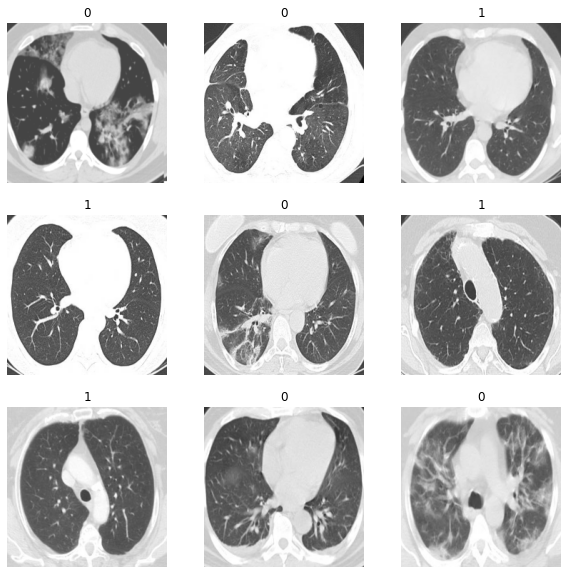

In [4]:
#plot some samples
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Data augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
       
    ]
)

In [6]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [7]:
input_shape=image_size + (3,)
inputs = keras.Input(shape=input_shape)

In [8]:
baseModel=tf.keras.applications.DenseNet201(weights="imagenet",include_top=False,
                input_shape=input_shape)
for layer in baseModel.layers:
    layer.trainable=False

In [9]:
x = layers.Rescaling(1.0 / 255)(inputs)
baseModel=baseModel(x)
headModel=tf.keras.layers.AveragePooling2D(pool_size=(2,2))(baseModel)
headModel=tf.keras.layers.Flatten(name="flatten")(headModel)
headModel=tf.keras.layers.Dense(128,activation="relu")(headModel)
headModel=tf.keras.layers.Dropout(0.2)(headModel)
headModel=tf.keras.layers.Dense(64,activation="relu")(headModel)
headModel=tf.keras.layers.Dropout(0.3)(headModel)
headModel=tf.keras.layers.Dense(1,activation="sigmoid")(headModel)

model=tf.keras.Model(inputs=inputs,outputs=headModel)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1920)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 17280)             0         
                                                                 
 dense (Dense)               (None, 128)               2211968   
                                                             

In [10]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
h=model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
63/63 [==============================] - 33s 312ms/step - loss: 0.7501 - accuracy: 0.6861 - val_loss: 0.5384 - val_accuracy: 0.7540
Epoch 2/5
63/63 [==============================] - 14s 216ms/step - loss: 0.3711 - accuracy: 0.8514 - val_loss: 0.2807 - val_accuracy: 0.8730
Epoch 3/5
63/63 [==============================] - 14s 220ms/step - loss: 0.2071 - accuracy: 0.9128 - val_loss: 0.1649 - val_accuracy: 0.9435
Epoch 4/5
63/63 [==============================] - 14s 213ms/step - loss: 0.1288 - accuracy: 0.9501 - val_loss: 0.1347 - val_accuracy: 0.9516
Epoch 5/5
63/63 [==============================] - 14s 212ms/step - loss: 0.0964 - accuracy: 0.9632 - val_loss: 0.1318 - val_accuracy: 0.9496


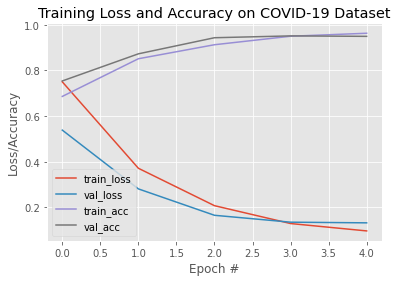

In [11]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), h.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), h.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), h.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), h.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [12]:
model.save("model.h5")

In [31]:
model=tf.keras.models.load_model("model.h5")
eval = model.evaluate(val_ds)

16/16 [==============================] - 5s 156ms/step - loss: 0.1318 - accuracy: 0.9496


In [35]:
img = keras.preprocessing.image.load_img(
    "samples/1.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Covid and %.2f percent Non-Covid."
    % (100 * (1 - score), 100 * score)
)

This image is 100.00 percent Covid and 0.00 percent Non-Covid.
